In [1]:
from zipfile import ZipFile
import pandas
import seaborn as sns
from io import BytesIO
import requests
import urllib.request

In [2]:
%matplotlib inline 

In [3]:
result = requests.get("https://www.covid19.admin.ch/api/data/20220117-ylc277il/downloads/sources-csv.zip")

In [4]:
zf = ZipFile(BytesIO(result.content))

dfs = dict()
for item in zf.namelist():
    if item.endswith('.csv'):
        df = pandas.read_csv(zf.open(item), encoding='latin-1', error_bad_lines=False, low_memory=False)
        dfs[item] = df


In [21]:
df_hosp_capacity = dfs['data/COVID19HospCapacity_geoRegion.csv']
df_hosp_ch = df_hosp_capacity[['date', 'geoRegion', 'ICU_NonCovid19Patients', 'ICU_Covid19Patients',
       'ICU_Capacity', 'Total_NonCovid19Patients', 'Total_Covid19Patients',
       'Total_Capacity']][df_hosp_capacity['geoRegion'] == 'CH']
df_hosp_ch = df_hosp_ch.loc[df_hosp_capacity['type_variant'] == 'fp7d']
df_hosp_ch_total = df_hosp_ch[['date', 'geoRegion', 'Total_NonCovid19Patients', 'Total_Covid19Patients', 'Total_Capacity']]
df_hosp_ch_total.insert(0, 'Total', df_hosp_ch_total['Total_NonCovid19Patients'].add(df_hosp_ch_total['Total_Covid19Patients']))

df_hosp_ch_total_2020 = df_hosp_ch_total[
    (df_hosp_ch_total['date'] <= '2020-31-12')
    & (df_hosp_ch_total['date'] > '2019-31-12')]

df_hosp_ch_total_2021 = df_hosp_ch_total[
    (df_hosp_ch_total['date'] <= '2021-31-12')
    & (df_hosp_ch_total['date'] > '2020-31-12')]

df_hosp_ch_total_2020.insert(0, 'dayOfYear', pandas.to_datetime(df_hosp_ch_total_2020['date']).dt.strftime('%m-%d'))
df_hosp_ch_total_2021.insert(0, 'dayOfYear', pandas.to_datetime(df_hosp_ch_total_2021['date']).dt.strftime('%m-%d'))

In [22]:
df_hosp_ch_total_2021

,dayOfYear,Total,date,geoRegion,Total_NonCovid19Patients,Total_Covid19Patients,Total_Capacity
35151,01-01,13420.0,2021-01-01,CH,10892.0,2528.0,22225.0
35152,01-02,13538.0,2021-01-02,CH,10970.0,2568.0,22128.0
35153,01-03,14105.0,2021-01-03,CH,11444.0,2661.0,22295.0
35154,01-04,15125.0,2021-01-04,CH,12428.0,2697.0,22573.0
35155,01-05,16381.0,2021-01-05,CH,13692.0,2689.0,22704.0
...,...,...,...,...,...,...,...
35511,12-27,14990.0,2021-12-27,CH,13269.0,1721.0,22370.0
35512,12-28,15573.0,2021-12-28,CH,13875.0,1698.0,22393.0
35513,12-29,15614.0,2021-12-29,CH,13883.0,1731.0,22354.0
35514,12-30,15306.0,2021-12-30,CH,13653.0,1653.0,22166.0


In [39]:
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [20, 10]
pyplot.rcParams.update({'font.size': 22})

In [40]:
df_2020 = df_hosp_ch_total_2020.set_index('dayOfYear', inplace=False).rolling(window=14).mean()['Total']
df_2021 = df_hosp_ch_total_2021.set_index('dayOfYear', inplace=False).rolling(window=14).mean()['Total']
df_2020.name = 'Hospitalisations 2020'
df_2021.name = 'Hospitalisations 2021'
output = pandas.DataFrame([df_2020, df_2021]).transpose().sort_index(inplace=False)

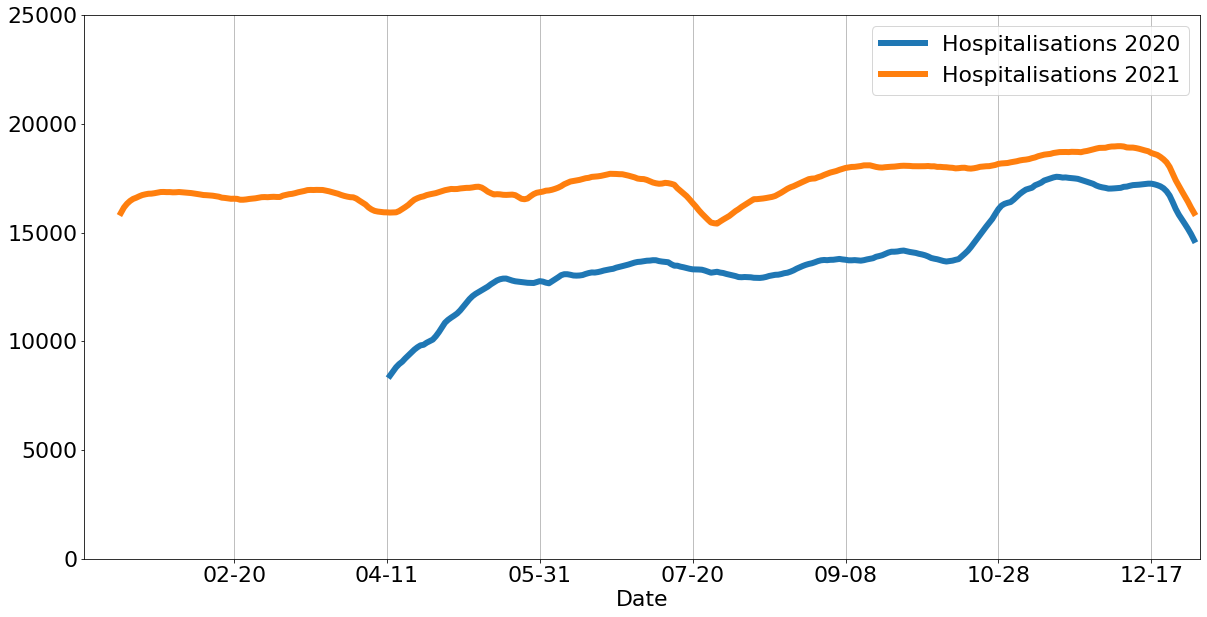

In [41]:
chart = output.plot(kind='line', xlim=(1, 366), ylim=(0, 25000), xlabel='Date', linewidth=6)
chart.grid(axis='x')